In [1]:
#To intstall gym library
#pip install gym

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Bernoulli
import torch.nn.functional as F
import numpy as np

In [2]:
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


In [3]:
env.action_space

Discrete(2)

In [4]:
env.observation_space

Box(4,)

In [5]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [6]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [7]:
env.reset()
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        print(observation, reward)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[ 0.02797955 -0.03454348  0.00434813 -0.0289451 ]
[ 0.02728868 -0.22972751  0.00376923  0.26510654]
[ 0.02269413 -0.03465956  0.00907136 -0.02638516]
[ 0.02200093 -0.22991042  0.00854366  0.26914602]
[ 0.01740273 -0.42515325  0.01392658  0.56451138]
[ 0.00889966 -0.23022943  0.02521681  0.27624829]
[ 0.00429507 -0.03547616  0.03074177 -0.00837579]
[ 0.00358555 -0.23102519  0.03057426  0.29384583]
[-0.00103495 -0.03635218  0.03645117  0.01096022]
[-0.001762   -0.23197742  0.03667038  0.31491742]
[-0.00640155 -0.42760202  0.04296873  0.61893573]
[-0.01495359 -0.23310575  0.05534744  0.34008952]
[-0.0196157  -0.42896975  0.06214923  0.64969947]
[-0.0281951  -0.62489983  0.07514322  0.96128731]
[-0.04069309 -0.82094687  0.09436897  1.27659935]
[-0.05711203 -0.62714638  0.11990095  1.01489538]
[-0.06965496 -0.43380975  0.14019886  0.76213901]
[-0.07833115 -0.63055581  0.15544164  1.09544603]
[-0.09094227 -0.43778421  0.17735056  0.85529096]
[-0.09969795 -0.63482198  0.19445638  1.19807984]


In [7]:
class Agent(nn.Module):
    def __init__(self, input_dim):
        super(Agent, self).__init__()
        self.linear = nn.Linear(input_dim, 2)
        self.Softmax= nn.Softmax()

    def forward(self, input):
        out = F.softmax(self.linear(input))
        return out

In [8]:
## hyperparameters
episodes = 5000
learning_rate = 0.001
gamma = 0.99


In [9]:
def discount_rewards(r):
    # compute discounted rewards using episode rewards (Q-value estimation)
    r = np.asarray(r)
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [10]:
agent = Agent(4)
optimizer = optim.SGD(agent.parameters(), lr=learning_rate)

In [11]:
def finish_ep(ep_logps, ep_rewards):
    R = discount_rewards(ep_rewards)
    for log_prob, r in zip(ep_logps, R):
        (-log_prob * r).backward()
    optimizer.step()
    optimizer.zero_grad()

In [12]:
## RUN POLICY GRADIENT ALGORITHM
total_reward = []
collector = []
for i in range(episodes):
    done = False
    reward = 0
    t = 0
    observation = Variable(torch.FloatTensor(env.reset())).resize(1,4)
    decay = 1
    running_reward = 0
    ep_actions = []
    ep_log_probs = []
    ep_rewards = []
    while not done:
        t += 1
        bernoulli_obj = Bernoulli((agent(observation)[0][0]).clamp(0,1))
        action = bernoulli_obj.sample()
        
        ep_log_probs.append(bernoulli_obj.log_prob(action))
        observation, reward, done, info = env.step(int(action.data[0]))
        observation = Variable(torch.FloatTensor(observation)).resize(1, 4)
        ep_rewards.append(reward)
        running_reward += reward
    finish_ep(ep_log_probs, ep_rewards)
    total_reward.append(running_reward)
        
    if i%50 == 0:
        print("average of 50 latest episode rewards:", sum(total_reward[-50:]) / 50)
        
    if i%10 == 0:
        collector.append(sum(total_reward[-50:]) / 50)


/Users/ccmbrucrew/anaconda2/lib/python2.7/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/Users/ccmbrucrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/Users/ccmbrucrew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


('average of 50 latest episode rewards:', 0.26)
('average of 50 latest episode rewards:', 34.86)
('average of 50 latest episode rewards:', 49.26)
('average of 50 latest episode rewards:', 87.66)
('average of 50 latest episode rewards:', 101.78)
('average of 50 latest episode rewards:', 114.38)
('average of 50 latest episode rewards:', 151.52)
('average of 50 latest episode rewards:', 74.16)
('average of 50 latest episode rewards:', 131.74)
('average of 50 latest episode rewards:', 125.96)
('average of 50 latest episode rewards:', 188.3)
('average of 50 latest episode rewards:', 108.7)
('average of 50 latest episode rewards:', 139.8)
('average of 50 latest episode rewards:', 190.76)
('average of 50 latest episode rewards:', 117.22)
('average of 50 latest episode rewards:', 177.48)
('average of 50 latest episode rewards:', 192.52)
('average of 50 latest episode rewards:', 189.24)
('average of 50 latest episode rewards:', 152.52)
('average of 50 latest episode rewards:', 155.4)
('average 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ccmbrucrew/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/ccmbrucrew/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/Users/ccmbrucrew/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/ccmbrucrew/anaconda2/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/Users/ccmbrucrew/anaconda2/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/Users/ccmbrucrew/anaconda2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, fi

IndexError: string index out of range

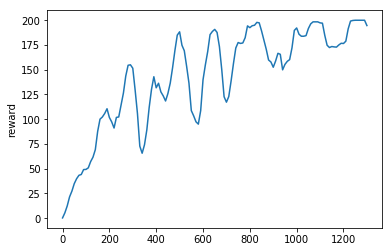

In [14]:
import matplotlib.pyplot as plt

plt.plot([x*10 for x in range(len(collector))], collector)
plt.ylabel('reward')

plt.show()


In [2]:
for _ in range(100):
    done = False
    observation = Variable(torch.FloatTensor(env.reset())).resize(1,4)
    while not done:
        env.render()
        bernoulli_obj = Bernoulli((agent(observation)[0][0]).clamp(0,1))
        action = bernoulli_obj.sample()
        observation, reward, done, info = env.step(int(action.data[0]))
        observation = Variable(torch.FloatTensor(observation)).resize(1, 4)


NameError: name 'Variable' is not defined

In [ ]:
https://www.youtube.com/watch?v=bsUY9wplVYw

In [ ]:
https://www.youtube.com/watch?v=gn4nRCC9TwQ&t=41s